# 0.사용할 라이브러리 import

In [1]:
import pandas
import konlpy
import gensim

# 1.데이터 불러오고 확인하기

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2.데이터로더 구성

id 컬럼을 통해 데이터 중복 확인

In [3]:
len(train_data['id'])

150000

In [4]:
len(set(train_data['id']))

150000

In [5]:
len(test_data['id'])

50000

In [6]:
len(set(test_data['id']))

50000

데이터 결측치 확인

In [7]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [8]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [9]:
train_data['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [10]:
'''
from konlpy.tag import Mecab

tokens=[]
tokenizer = Mecab()
tokens.append(tokenizer.morphs(train_data['document'][0]))

print(tokens)
'''

"\nfrom konlpy.tag import Mecab\n\ntokens=[]\ntokenizer = Mecab()\ntokens.append(tokenizer.morphs(train_data['document'][0]))\n\nprint(tokens)\n"

In [11]:
'''
train_data.dropna(axis=0,inplace = True)
train_data.reset_index(drop=True, inplace=True)  # 인덱스 재정렬

test_data.dropna(axis=0,inplace = True)
test_data.reset_index(drop=True, inplace=True)

from konlpy.tag import Mecab

tokenizer = Mecab()
tokens=[]
for x in range(len(train_data['document'])):
    token=tokenizer.morphs(train_data['document'][x])
    for y in range(len(token)):
        tokens.append(token[y])

for x in range(len(test_data['document'])):
    token=tokenizer.morphs(test_data['document'][x])
    for y in range(len(token)):
        tokens.append(token[y])

print(len(tokens))
'''

"\ntrain_data.dropna(axis=0,inplace = True)\ntrain_data.reset_index(drop=True, inplace=True)  # 인덱스 재정렬\n\ntest_data.dropna(axis=0,inplace = True)\ntest_data.reset_index(drop=True, inplace=True)\n\nfrom konlpy.tag import Mecab\n\ntokenizer = Mecab()\ntokens=[]\nfor x in range(len(train_data['document'])):\n    token=tokenizer.morphs(train_data['document'][x])\n    for y in range(len(token)):\n        tokens.append(token[y])\n\nfor x in range(len(test_data['document'])):\n    token=tokenizer.morphs(test_data['document'][x])\n    for y in range(len(token)):\n        tokens.append(token[y])\n\nprint(len(tokens))\n"

In [12]:
'''
tokens=[]
tokenizer = Mecab()
tokens.append(tokenizer.morphs(train_data['document'][0]))

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 불용어 제거
tokens_filtered = []

for token_list in tokens:
    filtered = [token for token in token_list if token not in stopwords]
    tokens_filtered.append(filtered)
    
print(tokens_filtered)
'''

"\ntokens=[]\ntokenizer = Mecab()\ntokens.append(tokenizer.morphs(train_data['document'][0]))\n\nstopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']\n\n# 불용어 제거\ntokens_filtered = []\n\nfor token_list in tokens:\n    filtered = [token for token in token_list if token not in stopwords]\n    tokens_filtered.append(filtered)\n    \nprint(tokens_filtered)\n"

In [13]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 빈도수 계산
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)  # 상위 num_words-4개의 단어 선택
    
    # 사전 구축
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3.모델 구성을 위한 데이터 분석 및 가공

In [16]:
import numpy as np
import tensorflow as tf
import os

maxlen=120

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

# 4.모델 구성 및 validation set 구성

RNN(LSTM)

In [17]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


1D CNN

In [18]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

1D CNN + RNN

In [19]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,689
Trainable params: 162,689
Non-trainable params: 0
________________________________________________

validation set 구성

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 5.모델 훈련 개시 / 6.Loss, Accuracy 그래프 시각화

Epoch 1/20
229/229 [==============================] - 6s 10ms/step - loss: 0.5504 - accuracy: 0.7537 - val_loss: 0.4126 - val_accuracy: 0.8351
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3555 - accuracy: 0.8533 - val_loss: 0.3531 - val_accuracy: 0.8493
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3178 - accuracy: 0.8684 - val_loss: 0.3503 - val_accuracy: 0.8496
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3036 - accuracy: 0.8745 - val_loss: 0.3501 - val_accuracy: 0.8488
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2939 - accuracy: 0.8782 - val_loss: 0.3512 - val_accuracy: 0.8483
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2905 - accuracy: 0.8801 - val_loss: 0.3539 - val_accuracy: 0.8489
Epoch 00006: early stopping
1537/1537 - 4s - loss: 0.3557 - accuracy: 0.8472


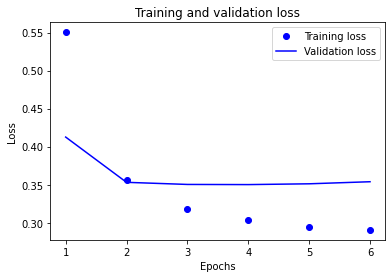

In [21]:
import keras

callbacks=[
    keras.callbacks.ModelCheckpoint("model1.keras",
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=2,
                                  verbose=1)
]

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)
results = model1.evaluate(x_test,  y_test, verbose=2)

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/20
229/229 [==============================] - 4s 8ms/step - loss: 0.5800 - accuracy: 0.6754 - val_loss: 0.4756 - val_accuracy: 0.7607
Epoch 2/20
229/229 [==============================] - 1s 7ms/step - loss: 0.4373 - accuracy: 0.7841 - val_loss: 0.4566 - val_accuracy: 0.7689
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4039 - accuracy: 0.8038 - val_loss: 0.4569 - val_accuracy: 0.7696
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3776 - accuracy: 0.8169 - val_loss: 0.4640 - val_accuracy: 0.7695
Epoch 00004: early stopping
1537/1537 - 3s - loss: 0.4668 - accuracy: 0.7702


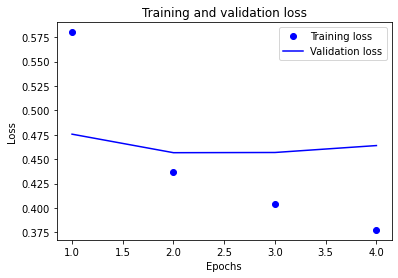

In [22]:
callbacks=[
    keras.callbacks.ModelCheckpoint("model1.keras",
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=2,
                                  verbose=1)
]

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)
results = model2.evaluate(x_test,  y_test, verbose=2)

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/20
229/229 [==============================] - 4s 9ms/step - loss: 0.5886 - accuracy: 0.6745 - val_loss: 0.4901 - val_accuracy: 0.7522
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.4488 - accuracy: 0.7806 - val_loss: 0.4604 - val_accuracy: 0.7683
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.4139 - accuracy: 0.8017 - val_loss: 0.4576 - val_accuracy: 0.7702
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3885 - accuracy: 0.8145 - val_loss: 0.4686 - val_accuracy: 0.7672
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3605 - accuracy: 0.8300 - val_loss: 0.4783 - val_accuracy: 0.7655
Epoch 00005: early stopping
1537/1537 - 3s - loss: 0.4851 - accuracy: 0.7629


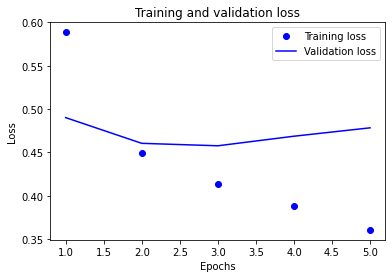

In [23]:
callbacks=[
    keras.callbacks.ModelCheckpoint("model1.keras",
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=2,
                                  verbose=1)
]

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model3.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)
results = model3.evaluate(x_test,  y_test, verbose=2)

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 7.학습된 Embedding 레이어 분석

Embedding 레이어에서 가중치 추출해 t-sne을 사용한 시각화

In [24]:
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

# Embedding 레이어에서 가중치 추출
embedding_weights = model1.layers[0].get_weights()[0]

# 단어와 인덱스를 매핑하는 딕셔너리
index_to_word = {index: word for word, index in word_to_index.items()}

# t-SNE를 사용하여 차원 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_weights)

# 시각화
plt.figure(figsize=(12, 12))
for index, word in index_to_word.items():
    if index >= len(reduced_embeddings):
        continue
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of Embeddings')
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n\n%matplotlib inline\n\n# Embedding 레이어에서 가중치 추출\nembedding_weights = model1.layers[0].get_weights()[0]\n\n# 단어와 인덱스를 매핑하는 딕셔너리\nindex_to_word = {index: word for word, index in word_to_index.items()}\n\n# t-SNE를 사용하여 차원 축소\ntsne = TSNE(n_components=2, random_state=42)\nreduced_embeddings = tsne.fit_transform(embedding_weights)\n\n# 시각화\nplt.figure(figsize=(12, 12))\nfor index, word in index_to_word.items():\n    if index >= len(reduced_embeddings):\n        continue\n    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])\n    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('t-SNE visualization of Embeddings')\nplt.show()\n"

In [25]:
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

# Embedding 레이어에서 가중치 추출
embedding_weights = model2.layers[0].get_weights()[0]

# 단어와 인덱스를 매핑하는 딕셔너리
index_to_word = {index: word for word, index in word_to_index.items()}

# t-SNE를 사용하여 차원 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_weights)

# 시각화
plt.figure(figsize=(12, 12))
for index, word in index_to_word.items():
    if index >= len(reduced_embeddings):
        continue
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of Embeddings')
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n\n%matplotlib inline\n\n# Embedding 레이어에서 가중치 추출\nembedding_weights = model2.layers[0].get_weights()[0]\n\n# 단어와 인덱스를 매핑하는 딕셔너리\nindex_to_word = {index: word for word, index in word_to_index.items()}\n\n# t-SNE를 사용하여 차원 축소\ntsne = TSNE(n_components=2, random_state=42)\nreduced_embeddings = tsne.fit_transform(embedding_weights)\n\n# 시각화\nplt.figure(figsize=(12, 12))\nfor index, word in index_to_word.items():\n    if index >= len(reduced_embeddings):\n        continue\n    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])\n    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('t-SNE visualization of Embeddings')\nplt.show()\n"

In [26]:
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

# Embedding 레이어에서 가중치 추출
embedding_weights = model3.layers[0].get_weights()[0]

# 단어와 인덱스를 매핑하는 딕셔너리
index_to_word = {index: word for word, index in word_to_index.items()}

# t-SNE를 사용하여 차원 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_weights)

# 시각화
plt.figure(figsize=(12, 12))
for index, word in index_to_word.items():
    if index >= len(reduced_embeddings):
        continue
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE visualization of Embeddings')
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n\n%matplotlib inline\n\n# Embedding 레이어에서 가중치 추출\nembedding_weights = model3.layers[0].get_weights()[0]\n\n# 단어와 인덱스를 매핑하는 딕셔너리\nindex_to_word = {index: word for word, index in word_to_index.items()}\n\n# t-SNE를 사용하여 차원 축소\ntsne = TSNE(n_components=2, random_state=42)\nreduced_embeddings = tsne.fit_transform(embedding_weights)\n\n# 시각화\nplt.figure(figsize=(12, 12))\nfor index, word in index_to_word.items():\n    if index >= len(reduced_embeddings):\n        continue\n    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])\n    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=9)\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('t-SNE visualization of Embeddings')\nplt.show()\n"

gensim을 활용해 자체학습된 임베딩 레이어 분석

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors1.similar_by_word("사랑")

[('오묘', 0.9793975949287415),
 ('장혁', 0.9776970744132996),
 ('공연', 0.9752406477928162),
 ('Good', 0.9739882349967957),
 ('잼따', 0.9738390445709229),
 ('들어도', 0.972054123878479),
 ('엄청나', 0.9708358645439148),
 ('love', 0.9702436923980713),
 ('열린', 0.969426155090332),
 ('그대', 0.966931164264679)]

In [28]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors2.similar_by_word("사랑")

[('도박', 0.9540598392486572),
 ('짙', 0.924099862575531),
 ('알맞', 0.9220335483551025),
 ('음악', 0.9195846915245056),
 ('몰입', 0.9192200899124146),
 ('무척', 0.915824294090271),
 ('보람', 0.9118862152099609),
 ('김남길', 0.9074744582176208),
 ('bbbb', 0.906970202922821),
 ('바람직', 0.9026119112968445)]

In [29]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec3.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors3.similar_by_word("사랑")

[('리들리스콧', 0.9339684844017029),
 ('아름답', 0.9270418882369995),
 ('쌀', 0.926131010055542),
 ('낸', 0.9184611439704895),
 ('ㅎㅎ', 0.9181113839149475),
 ('일어났', 0.916582465171814),
 ('쏠쏠', 0.9081268310546875),
 ('레전드', 0.9025816321372986),
 ('금물', 0.8965854644775391),
 ('놓치', 0.895613431930542)]

모델 3개다 사랑이랑 거리가 먼 단어를 유사 단어로 찾아 주었다.

성능은 별로인 듯 하다.

# 8.한국어 Word2Vec 임베딩 활용하여 성능 개선

In [30]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 경로를 절대 경로로 변환
word2vec_file_path = os.path.expanduser('~/data/word2vec_ko.model')

# 모델 로드
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)

In [31]:
vector_dim = word2vec.wv.vector_size
print(vector_dim)

100


In [32]:
import numpy as np

# 예시 변수들
vocab_size = 10000  # 단어 집합 크기
word_vector_dim = 100  # 워드 벡터 차원

# 무작위로 초기화된 embedding_matrix
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# index_to_word와 word_vectors.wv를 사용해 embedding_matrix를 채우는 코드
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

모델1을 이용해 한국어 Word2Vec 임베딩을 사용한 재학습

Epoch 1/20
229/229 [==============================] - 4s 11ms/step - loss: 0.4905 - accuracy: 0.7824 - val_loss: 0.3686 - val_accuracy: 0.8448
Epoch 2/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3318 - accuracy: 0.8620 - val_loss: 0.3480 - val_accuracy: 0.8488
Epoch 3/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3013 - accuracy: 0.8740 - val_loss: 0.3432 - val_accuracy: 0.8508
Epoch 4/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2810 - accuracy: 0.8831 - val_loss: 0.3477 - val_accuracy: 0.8517
Epoch 5/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2626 - accuracy: 0.8908 - val_loss: 0.3500 - val_accuracy: 0.8534
Epoch 00005: early stopping
1537/1537 - 4s - loss: 0.3551 - accuracy: 0.8482


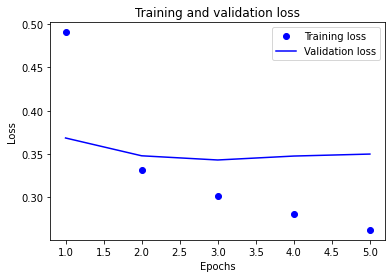

In [33]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

callbacks=[
    keras.callbacks.ModelCheckpoint("model1.keras",
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=2,
                                  verbose=1)
]

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)
results = model4.evaluate(x_test,  y_test, verbose=2)

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
embedding_layer = model4.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec4.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model4.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors4 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors4.similar_by_word("사랑")

[('멋지', 0.8865188956260681),
 ('표현', 0.874286413192749),
 ('입감', 0.8696072101593018),
 ('천재', 0.869078516960144),
 ('소장', 0.8644410371780396),
 ('훌륭', 0.8621915578842163),
 ('보석', 0.8575947880744934),
 ('참신', 0.8571383953094482),
 ('꽉', 0.856636106967926),
 ('열린', 0.8555484414100647)]

모델를 재구성해 한국어 Word2Vec 임베딩을 사용한 학습

Epoch 1/20
229/229 [==============================] - 158s 677ms/step - loss: 0.4669 - accuracy: 0.7875 - val_loss: 0.3625 - val_accuracy: 0.8423
Epoch 2/20
229/229 [==============================] - 155s 676ms/step - loss: 0.3488 - accuracy: 0.8571 - val_loss: 0.3485 - val_accuracy: 0.8489
Epoch 3/20
229/229 [==============================] - 155s 677ms/step - loss: 0.3202 - accuracy: 0.8704 - val_loss: 0.3460 - val_accuracy: 0.8512
Epoch 4/20
229/229 [==============================] - 155s 676ms/step - loss: 0.2985 - accuracy: 0.8815 - val_loss: 0.3429 - val_accuracy: 0.8542
Epoch 5/20
229/229 [==============================] - 155s 676ms/step - loss: 0.2790 - accuracy: 0.8897 - val_loss: 0.3420 - val_accuracy: 0.8558
Epoch 6/20
229/229 [==============================] - 155s 676ms/step - loss: 0.2607 - accuracy: 0.8982 - val_loss: 0.3488 - val_accuracy: 0.8558
Epoch 7/20
229/229 [==============================] - 155s 676ms/step - loss: 0.2447 - accuracy: 0.9050 - val_loss: 0.3538 -

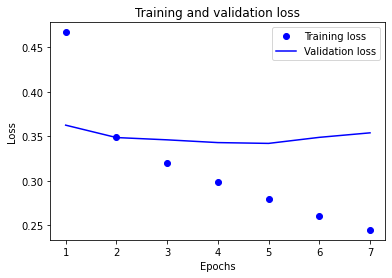

In [35]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(16, recurrent_dropout=0.5, return_sequences=True))
model.add(tf.keras.layers.GRU(16, recurrent_dropout=0.5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

callbacks=[
    keras.callbacks.ModelCheckpoint("model1.keras",
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=2,
                                  verbose=1)
]

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)

# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/Exploration/Ex05/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('~~^^', 0.8424305319786072),
 ('졌으면', 0.8376133441925049),
 ('수작', 0.8374435305595398),
 ('감탄', 0.8325133323669434),
 ('동전', 0.8320947289466858),
 ('해집니다', 0.8292805552482605),
 ('great', 0.827401340007782),
 ('즐거웠', 0.826595664024353),
 ('자격', 0.8252105116844177),
 ('오스카', 0.8250316977500916)]

기존 lstm 모델보단 스테킹 Gru 모델이 성능은 좋았으나, 사랑이란 단어로 유사 단어를 찾았을땐 기존 lstm 모델이 더 유사한 단어를 찾아 준것으로 보인다. 

물론 앞에서 실시 했던 모델 3개보단 이 두 모델이 훨씬 좋다.

## 회고

한국어 Word2Vec 임베딩을 사용하니까 추론 성능이

loss: 0.3557 - accuracy: 0.8472 -> loss: 0.3551 - accuracy: 0.8482로 약간 좋아진 모습을 보인다!

또한 유사단어 찾는 성능도 훨씬 좋아졌다.

다만 신기한점은 기존 lstm 모델보단 스테킹 Gru 모델이 성능은 좋았으나, 사랑이란 단어로 유사 단어를 찾았을땐 기존 lstm 모델이 더 유사한 단어를 찾아 준것으로 보인다는 점이다!

역시 좋은 임베딩을 사용해야 모델이 조금 더 좋아진다는것을 이번 프로젝트를 하면서 느꼈다.